In [70]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [71]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#load dataset
mnist = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(mnist, batch_size=64, shuffle=True)


In [72]:
print("Total samples:",len(mnist))

Total samples: 60000


In [73]:
print(len(train_loader))

938


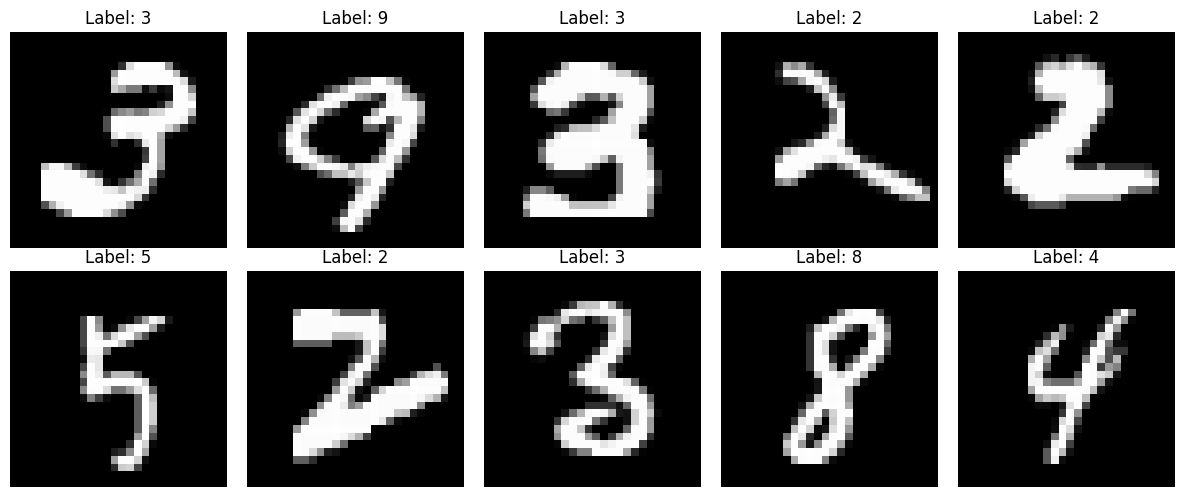

In [74]:
# Create a figure to display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

# Display 10 random images
indices = np.random.randint(0, len(mnist), 10)
for i, idx in enumerate(indices):
    img, label = mnist[idx]
    img = img.squeeze().numpy()  

    # Denormalize from [-1,1] to [0,1]
    img = img * 0.5 + 0.5
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('mnist_samples.png')

In [75]:
# ------------------------------
# 2. Define Autoencoder with DEC
# ------------------------------
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)


In [76]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2),
            nn.Tanh()
        )

    def forward(self, z):
        return self.decoder(z)


In [77]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

In [78]:
import torch.nn.functional as F
# ------------------------------
# 3. DEC Clustering Module
# ------------------------------
class DECClustering(nn.Module):
    def __init__(self, n_clusters, embedding_dim):
        super().__init__()
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, embedding_dim))

    def soft_assign(self, z):
        # Student’s t-distribution, q_ij
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2))
        q = q ** ((1 + 1) / 2)  # α = 1
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q

    def target_distribution(self, q):
        # Sharpen and normalize, pij
        weight = q ** 2 / torch.sum(q, dim=0)
        p = (weight.t() / torch.sum(weight, dim=1)).t()
        return p


In [79]:
# ------------------------------
# 3. Setup Model and Training
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 64
n_clusters = 10
lambda_clust = 0.1

model = ConvAutoencoder(latent_dim).to(device)
cluster_module = DECClustering(n_clusters=n_clusters, embedding_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(cluster_module.parameters()), lr=1e-3)


In [80]:
# ------------------------------
# 4. Training Loop
# ------------------------------
epochs = 35
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        z = model.encoder(images)
        x_recon = model.decoder(z)
        recon_loss = criterion(x_recon, images)

        # DEC clustering loss
        q = cluster_module.soft_assign(z)
        p = cluster_module.target_distribution(q).detach()
        kl_loss = F.kl_div(q.log(), p, reduction='batchmean')

        # Total loss
        loss = recon_loss + lambda_clust * kl_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - Recon Loss: {recon_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}, Total Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/35] - Recon Loss: 0.0820, KL Loss: 0.0128, Total Loss: 0.1442
Epoch [2/35] - Recon Loss: 0.0795, KL Loss: 0.1924, Total Loss: 0.0971
Epoch [3/35] - Recon Loss: 0.0825, KL Loss: 0.2126, Total Loss: 0.1028
Epoch [4/35] - Recon Loss: 0.0827, KL Loss: 0.1987, Total Loss: 0.0991
Epoch [5/35] - Recon Loss: 0.0745, KL Loss: 0.1966, Total Loss: 0.0958
Epoch [6/35] - Recon Loss: 0.0800, KL Loss: 0.1762, Total Loss: 0.0936
Epoch [7/35] - Recon Loss: 0.0739, KL Loss: 0.1954, Total Loss: 0.0915
Epoch [8/35] - Recon Loss: 0.0657, KL Loss: 0.1941, Total Loss: 0.0899
Epoch [9/35] - Recon Loss: 0.0715, KL Loss: 0.1913, Total Loss: 0.0886
Epoch [10/35] - Recon Loss: 0.0647, KL Loss: 0.1643, Total Loss: 0.0872
Epoch [11/35] - Recon Loss: 0.0655, KL Loss: 0.1703, Total Loss: 0.0858
Epoch [12/35] - Recon Loss: 0.0688, KL Loss: 0.1517, Total Loss: 0.0845
Epoch [13/35] - Recon Loss: 0.0625, KL Loss: 0.1342, Total Loss: 0.0831
Epoch [14/35] - Recon Loss: 0.0718, KL Loss: 0.1659, Total Loss: 0.0822
E

In [81]:
from sklearn.preprocessing import StandardScaler

model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for images, lbls in train_loader:
        images = images.to(device)
        z = model.encoder(images)
        embeddings.append(z.cpu())
        labels.append(lbls)

# Concatenate all batches into one tensor
embeddings = torch.cat(embeddings, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

# Normalize the final embeddings with StandardScaler
embeddings = StandardScaler().fit_transform(embeddings)


In [82]:
# Clustering with K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score

kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
cluster_preds = kmeans.fit_predict(embeddings)


sil_score = silhouette_score(embeddings, cluster_preds)
print(f"Silhouette Score: {sil_score:.4f}")


db_index = davies_bouldin_score(embeddings, cluster_preds)
print(f"Davies-Bouldin Index: {db_index:.4f}")


ch_score = calinski_harabasz_score(embeddings, cluster_preds)
print(f"Calinski-Harabasz Index: {ch_score:.2f}")

Silhouette Score: 0.5319
Davies-Bouldin Index: 0.8520
Calinski-Harabasz Index: 181744.91


In [83]:
!pip install seaborn

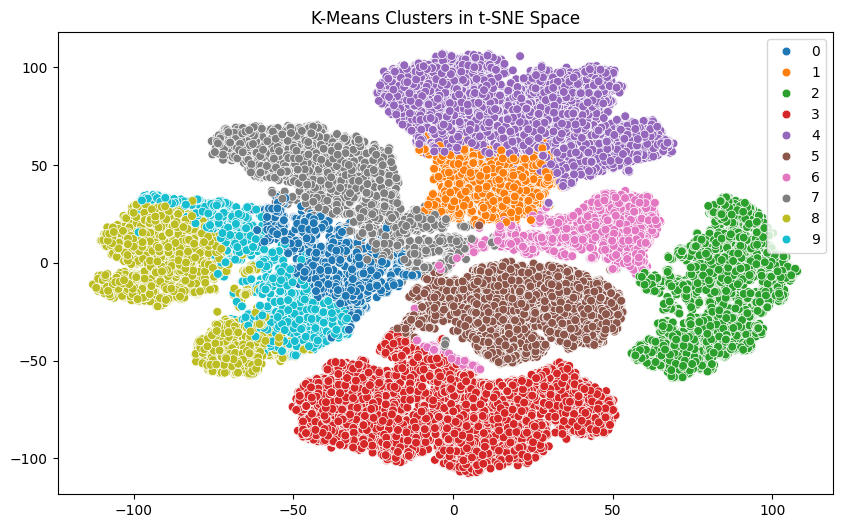

In [84]:
# visualiztion
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=cluster_preds, palette='tab10', s=40)
plt.title("K-Means Clusters in t-SNE Space")
plt.savefig("kmeans_tsne_clusters.png")


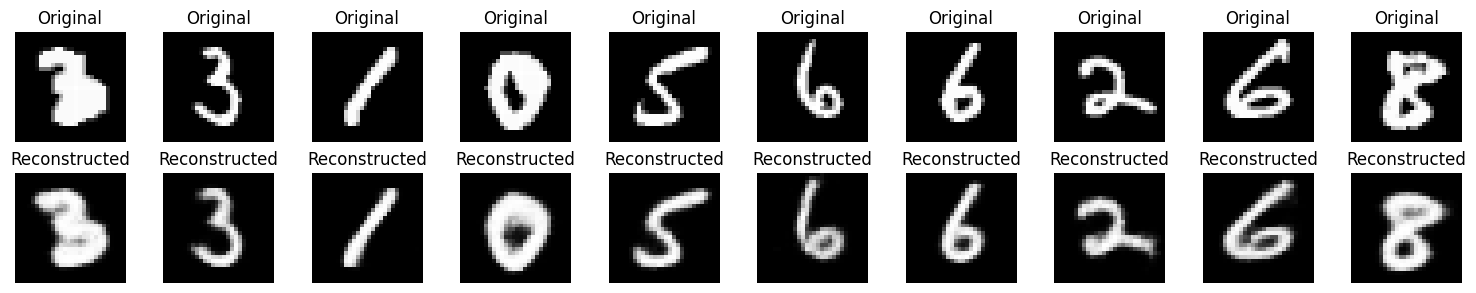

In [85]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Get a batch of images
images, _ = next(iter(train_loader))
images = images.to(device)

# Pass through the autoencoder
with torch.no_grad():
    reconstructions = model.decoder(model.encoder(images))

# Plot original vs reconstructed
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Original Images
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # Reconstructed Images
    axes[1, i].imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
